# Project 4: Predict West Nile Virus
### Section 5. Model Exploration

## Problem Statement

1. As an employee of Disease And Treatment Agency, division of Societal Cures In Epidemiology and New Creative Engineering (DATA-SCIENCE), we are tasked to better understand the mosquito population and advise on appropriate interventions which are beneficial and cost-effective for the city.


2. Through this project, we hope to:
- Identify features which are most important to predict presence of West Nile Virus (which can be done by ranking the coefficients of each feature in a logistic regression model)
- Predict the probability of West Nile Virus by location to provide decision makers an effective plan to deploy pesticides throughout the city, which consequently can help to reduce cost.

## Import Libraries

In [32]:
#!pip install shapely
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# from shapely import geometry
# from shapely.geometry import Point, Polygon
# import geopandas as gpd
# from datetime import timedelta
# import math

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import (confusion_matrix, plot_confusion_matrix, classification_report, 
                             plot_roc_curve, roc_auc_score, accuracy_score, precision_score, 
                             recall_score, f1_score)
from imblearn.over_sampling import SMOTE

## Load Data

In [33]:
# Load datasets
df = pd.read_csv('../data/final_df.csv', index_col='Unnamed: 0')

### Split into train and test (Kaggle) data

In [34]:
# Split into train and test (kaggle) data 
train = df[df['dataset']=='train'].copy()
test = df[df['dataset']=='test'].copy()
print(train.shape)
print(test.shape)

(8304, 240)
(43035, 240)


In [35]:
train.drop(columns='dataset', inplace=True)
test.drop(columns='dataset', inplace=True)

In [36]:
train.describe()

,latitude,longitude,tavg,preciptotal,stnpressure,resultdir,avgspeed,is_spray,stnpressure_7,stnpressure_10,...,codesum_TSRA BR HZ VCTS,codesum_TSRA FG+ BR HZ,codesum_TSRA RA,codesum_TSRA RA BR,codesum_TSRA RA BR HZ,codesum_TSRA RA BR HZ VCTS,codesum_TSRA RA BR VCTS,codesum_TSRA RA VCTS,codesum_VCTS,wnvpresent
count,8304.000000,8304.000000,8304.000000,8304.000000,8304.000000,8304.000000,8304.000000,8304.000000,8304.000000,8304.000000,...,8304.000000,8304.0,8304.000000,8304.000000,8304.0,8304.0,8304.000000,8304.0,8304.000000,8304.000000
mean,41.845800,-87.696229,72.093931,0.182431,29.262110,17.842245,7.476903,0.008911,29.277200,29.265990,...,0.006142,0.0,0.029383,0.037211,0.0,0.0,0.010597,0.0,0.003974,0.055034
std,0.106658,0.084440,7.630330,0.470450,0.118606,9.433945,2.543438,0.093984,0.126573,0.142227,...,0.078132,0.0,0.168889,0.189290,0.0,0.0,0.102402,0.0,0.062918,0.228060
min,41.644612,-87.930995,50.000000,0.000000,28.890000,1.000000,2.100000,0.000000,28.890000,28.910000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
25%,41.750498,-87.752411,69.000000,0.000000,29.180000,8.000000,5.800000,0.000000,29.210000,29.180000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
50%,41.862292,-87.696269,73.000000,0.000000,29.260000,19.000000,7.100000,0.000000,29.280000,29.260000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
75%,41.947227,-87.648064,78.000000,0.160000,29.340000,25.000000,9.400000,0.000000,29.380000,29.360000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
max,42.017430,-87.531635,87.000000,3.970000,29.650000,36.000000,16.300000,1.000000,29.650000,29.650000,...,1.000000,0.0,1.000000,1.000000,0.0,0.0,1.000000,0.0,1.000000,1.000000


In [37]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8304 entries, 0 to 8303
Columns: 239 entries, latitude to wnvpresent
dtypes: float64(11), int64(228)
memory usage: 15.2 MB


### Further Split Train Data into Train and Holdout

In [38]:
# Split train data into X (all features except wnvpresent) and y (wnvpresent)
features = [col for col in train.columns if col != 'wnvpresent']
X = train[features]
y = train['wnvpresent']

In [39]:
X.columns[X.isna().any()].tolist()

[]

In [40]:
y.value_counts(normalize = True)

0.0    0.944966
1.0    0.055034
Name: wnvpresent, dtype: float64

- wnvpresent is highly inbalance, with only about 5.5% of the data points having West Nile Virus. 
    - It is important to stratify proportionally to ensure that our train and holdout dataset have about the same proportion of presence and absence of West Nile Virus.
    - We also need to use SMOTE as the accuracy of our models without SMOTE is about 95% (i.e. close to the proportion of absence of WNV)

In [41]:
# Further split train data into train and holdout data
X_train, X_holdout, y_train, y_holdout = train_test_split(
    X, 
    y,
    stratify = y,
    random_state=42
)

In [42]:
# Scale our data
ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_holdout = ss.transform(X_holdout)

## Create synthetic data with SMOTE

In [43]:
# create synthetic data for train set
sm = SMOTE()
Xsm_train, ysm_train = sm.fit_resample(Xs_train, y_train)

In [44]:
Xsm_train.shape

(11770, 238)

## Model Exploration

### Metrics to Evaluate Models

In [253]:
# Creacting a summary dataframe.
summary_df = pd.DataFrame(columns=[
    'model', 
    'best_score', 
    'train_score',
    'holdout_score',
    'sensitivity',
    'specificity',
    'precision',
    'f1_score',
    'best_params', 
])

In [254]:
summary_df

,model,best_score,train_score,holdout_score,sensitivity,specificity,precision,f1_score,best_params


In [255]:
def model_metrics(gs, X_train, y_train, X_test, y_test, modelname):
    '''Generates confusion matrix and adds scores to summary_df'''
    
    #Generate confusion matrix
    y_pred = gs.predict(X_test)
    confusion_matrix(y_test, # True values.
                     y_pred)  # Predicted values.
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel();
    y_train_pred_prob = gs.predict_proba(X_train)[:,1]
    y_test_pred_prob = gs.predict_proba(X_test)[:,1]
    
    summary_df_rows = summary_df.shape[0]
    # Adding the scores into summary_df
    summary_df.loc[summary_df_rows] = [
        modelname,
        #'CountVec/LogisticRegression',
        round(gs.best_score_, 3),
        round(metrics.roc_auc_score(y_train, y_train_pred_prob),3),
        round(metrics.roc_auc_score(y_test, y_test_pred_prob),3),
        round(metrics.recall_score(y_test, y_pred),3),
        round(tn/(tn+fp),3),
        round(tp / (tp + fp), 3),
        round(metrics.f1_score(y_test, y_pred),3),
        str(gs.best_params_),
    ]
    
    
    
    # Plot Confusion Matrix
    plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', 
                          display_labels=['WNV Present', 'WNV Not Present'],
                          normalize='true');  
    plt.title(label=modelname, fontsize=14)
    plt.grid(False)

In [256]:
def model_metrics_2(gs, X_train, y_train, X_test, y_test, modelname):
    '''Generates confusion matrix and adds scores to summary_df'''
    
    #Generate confusion matrix
    y_pred = gs.predict(X_test)
    confusion_matrix(y_test, # True values.
                     y_pred)  # Predicted values.
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel();
    
    # y_train_pred_prob = gs.predict_proba(X_train)[:,1]
    # y_test_pred_prob = gs.predict_proba(X_test)[:,1]
    
    summary_df_rows = summary_df.shape[0]
    # Adding the scores into summary_df
    summary_df.loc[summary_df_rows] = [
        modelname,
        #'CountVec/LogisticRegression',
        round(gs.best_score_, 3),
        round(gs.score(X_train, y_train), 3),
        round(gs.score(X_test, y_test), 3),
        # round(metrics.roc_auc_score(y_train, y_train_pred_prob),3),
        # round(metrics.roc_auc_score(y_test, y_test_pred_prob),3),
        round(metrics.recall_score(y_test, y_pred),3),
        round(tn/(tn+fp),3),
        round(tp / (tp + fp), 3),
        round(metrics.f1_score(y_test, y_pred),3),
        str(gs.best_params_),
    ]
    
    
    
    # Plot Confusion Matrix
    plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', 
                          display_labels=['WNV Present', 'WNV Not Present'],
                          normalize='true');  
    plt.title(label=modelname, fontsize=14)
    plt.grid(False)

### Logistic Regression

In [17]:
# Instantiate model
logreg = LogisticRegression()

# Fit model
logreg.fit(Xs_train, y_train)

print(f'Logistic Regression Intercept: {logreg.intercept_}')
print(f'Logistic Regression Coefficient: {logreg.coef_}')

Logistic Regression Intercept: [-5.18323133]
Logistic Regression Coefficient: [[-2.90981683e-01 -2.39494869e-01  1.20605658e-01 -4.46864103e-02
  -1.77380567e-01  9.33355749e-02  4.64534901e-03  1.82344515e-02
   2.41123229e-01  3.66215617e-01 -2.51145035e-01  1.07436511e-01
   7.66391295e-02  2.13631312e-02  8.83433504e-02  4.47363858e-02
   0.00000000e+00  1.90894303e-03  1.23503031e-01  1.90894303e-03
  -1.58690491e-03 -1.24579015e-01  0.00000000e+00 -3.25159298e-01
   0.00000000e+00 -1.45101636e-01  0.00000000e+00  7.98163586e-01
   0.00000000e+00 -5.35010920e-01 -6.57602378e-01 -4.93489870e-01
  -5.27740017e-01 -2.67095294e-01 -1.76984073e-01 -3.81070128e-01
   1.45818271e-01  6.15254514e-01  6.89091224e-01  7.61921264e-01
   5.50280090e-01  4.46966814e-01  4.50268033e-01  4.20930769e-01
   3.64039416e-01 -2.12861050e-01  2.55178077e-01 -1.60453802e-01
   1.26126812e-01 -1.19745867e-03 -5.79895061e-01  9.20801593e-02
  -4.43876973e-02 -4.58541676e-01  2.23141936e-01  0.00000000e+0

C:\Users\deang\anaconda3\envs\dsi\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [18]:
# Display Coefficients
coefs = pd.DataFrame({'variable':X.columns,
                            'coef':logreg.coef_[0],
                            'abs_coef':np.abs(logreg.coef_[0])
                     })

coefs.sort_values('abs_coef', inplace=True, ascending=False)
coefs.head(20)

,variable,coef,abs_coef
27,year_2013,0.798164,0.798164
39,week_33,0.761921,0.761921
38,week_32,0.689091,0.689091
30,week_24,-0.657602,0.657602
37,week_31,0.615255,0.615255
50,dayofweek_3,-0.579895,0.579895
40,week_34,0.550280,0.550280
212,codesum_RA BR,-0.541623,0.541623
29,week_23,-0.535011,0.535011
32,week_26,-0.527740,0.527740


In [19]:
logreg.score(Xs_train, y_train), logreg.score(Xs_holdout, y_holdout)

(0.9449261400128453, 0.9436416184971098)

In [20]:
# Summary scores of CountVectorizer and LogisticRegression.
print("LogisticRegression summary of accuracy scores:")
#print(f"GridSearchCV best accuracy = {round(gs_pipe.best_score_, 3)}")
print("\nUsing GridSearchCV best params suggested,")
print(f"Training corpus accuracy = {round(logreg.score(X_train, y_train), 3)}")
print(f"Testing corpus accuracy = {round(logreg.score(X_holdout, y_holdout), 3)}")

LogisticRegression summary of accuracy scores:

Using GridSearchCV best params suggested,
Training corpus accuracy = 0.055
Testing corpus accuracy = 0.055


C:\Users\deang\anaconda3\envs\dsi\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\deang\anaconda3\envs\dsi\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


### Multinomial NB

### Random Forest

### SVM

### AdaBoostClassifier

In [53]:
ada = AdaBoostClassifier(
    n_estimators = 100,
    learning_rate = 0.9
    # in general, if n_estimators is high, then learning_rate should be low
    # but we can use GridSearchCV
)
ada.fit(Xsm_train, ysm_train)
ada.score(Xs_holdout, y_holdout)

0.9089595375722543

In [54]:
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())
ada_params = {
    'n_estimators': [50, 100, 150],
    'base_estimator__max_depth': [1,2],
    'learning_rate': [.8, .9, 1.]
    # you can also tune by all hyperparameters of DecisionTree
}
gs = GridSearchCV(
    ada, 
    param_grid=ada_params, 
    cv=5
)
gs.fit(Xsm_train, ysm_train)
gs.score(Xs_holdout, y_holdout)

0.9277456647398844

In [55]:
tn, fp, fn, tp = confusion_matrix(y_holdout, gs.predict(Xs_holdout)).ravel()

In [56]:
sensitivity = tp / (tp + fn)
sensitivity

0.14912280701754385

In [57]:
precision = tp / (tp + fp)
precision

0.24285714285714285

C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


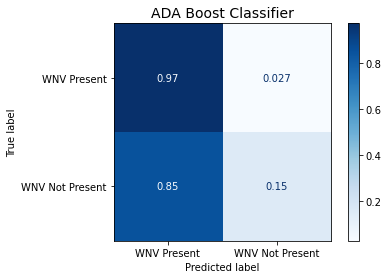

In [58]:
model_metrics(gs, Xsm_train, ysm_train, Xs_holdout, y_holdout, 'ADA Boost Classifier')

C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


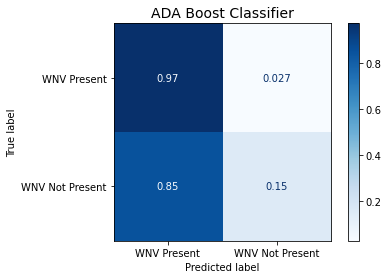

In [96]:
model_metrics_2(gs, Xsm_train, ysm_train, Xs_holdout, y_holdout, 'ADA Boost Classifier')

In [97]:
summary_df

,model,best_score,train_score,holdout_score,sensitivity,specificity,f1_score,best_params
0,ADA Boost Classifier,0.957,0.997,0.791,0.149,0.973,0.185,"{'base_estimator__max_depth': 2, 'learning_rat..."
1,Gradient Boosting Classifier,0.955,0.479,0.471,1.000,0.000,0.104,"{'learning_rate': 0.12, 'max_depth': 4, 'n_est..."
2,Gradient Boosting Classifier,0.955,0.996,0.853,0.149,0.982,0.204,"{'learning_rate': 0.12, 'max_depth': 4, 'n_est..."
3,ADA Boost Classifier,0.957,0.971,0.928,0.149,0.973,0.185,"{'base_estimator__max_depth': 2, 'learning_rat..."


In [60]:
print(gs.best_score_)
gs.best_params_

0.9570093457943925


{'base_estimator__max_depth': 2, 'learning_rate': 0.9, 'n_estimators': 100}

<AxesSubplot:>

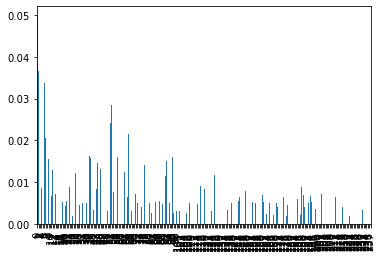

In [61]:
pd.Series(gs.best_estimator_.feature_importances_).plot.bar()

### Gradient Boosting Classifier

In [62]:
gboost = GradientBoostingClassifier()
gboost_params = {
    'max_depth': [2, 3, 4],
    'n_estimators': [100, 125, 150],
    'learning_rate': [.08, .1, .12]
}
gb_gs = GridSearchCV(
    gboost, 
    param_grid=gboost_params, 
    cv=3
)
gb_gs.fit(Xsm_train, ysm_train)
gb_gs.score(Xs_holdout, y_holdout)

0.9359344894026975

In [63]:
print(gb_gs.best_score_)
gb_gs.best_params_

0.9553140435545308


{'learning_rate': 0.12, 'max_depth': 4, 'n_estimators': 150}

In [ ]:
#0.955	0.996	0.853	

In [64]:
tn, fp, fn, tp = confusion_matrix(y_holdout, gb_gs.predict(Xs_holdout)).ravel()

In [65]:
sensitivity = tp / (tp + fn)
sensitivity

0.14912280701754385

In [66]:
precision = tp / (tp + fp)
precision

0.32075471698113206

In [67]:
confusion_matrix(y_holdout, gb_gs.predict(Xs_holdout))

array([[1926,   36],
       [  97,   17]], dtype=int64)

C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


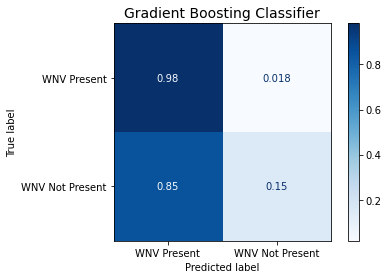

In [257]:
model_metrics(gb_gs, Xsm_train, ysm_train, Xs_holdout, y_holdout, 'Gradient Boosting Classifier')

C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


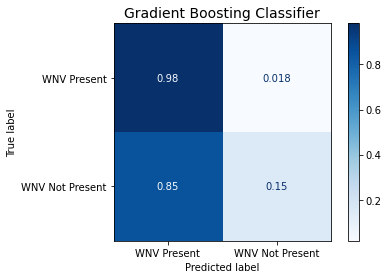

In [258]:
model_metrics_2(gb_gs, Xsm_train, ysm_train, Xs_holdout, y_holdout, 'Gradient Boosting Classifier')

In [259]:
summary_df

,model,best_score,train_score,holdout_score,sensitivity,specificity,precision,f1_score,best_params
0,Gradient Boosting Classifier,0.955,0.996,0.853,0.149,0.982,0.321,0.204,"{'learning_rate': 0.12, 'max_depth': 4, 'n_est..."
1,Gradient Boosting Classifier,0.955,0.974,0.936,0.149,0.982,0.321,0.204,"{'learning_rate': 0.12, 'max_depth': 4, 'n_est..."


### Neural Network

In [286]:
def model_metrics_nn(model, modelname):
    '''Generates confusion matrix and adds scores to summary_df'''
    #Generate confusion matrix
    tn, fp, fn, tp = confusion_matrix(ysm_train, model.predict_classes(Xsm_train)).ravel();
    acc_train = (tn + tp) / (tn + fp + fn + tp)

    y_pred = model.predict_classes(Xs_holdout)
    confusion_matrix(y_holdout, # True values.
                     y_pred)  # Predicted values.
    tn, fp, fn, tp = confusion_matrix(y_holdout, y_pred).ravel();
    acc = (tn + tp) / (tn + fp + fn + tp)
    sens = tp / (tp + fn)
    spec = tn / (tn + fp)
    prec = tp / (tp + fp)
    f1_score = 2 * (prec*sens) / (prec + sens)


    summary_df_rows = summary_df.shape[0]
    # Adding the scores into summary_df
    summary_df.loc[summary_df_rows] = [
        modelname,
        '',
        round(acc_train,3), # accuracy of train
        round(acc,3), # accuracy of holdout
        round(sens,3), # sensitivity of holdout
        round(spec,3), # specificity of holdout
        round(prec,3), # specificity of holdout
        round(f1_score,3), # f1 score of holdout
        '',
    ]

In [287]:
model = Sequential()
model.add(Dense(64,
                input_shape=(238,),
                activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [288]:
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

In [289]:
history = model.fit(Xsm_train, ysm_train, validation_data=(Xs_holdout, y_holdout), epochs=2, batch_size=512, verbose=0)

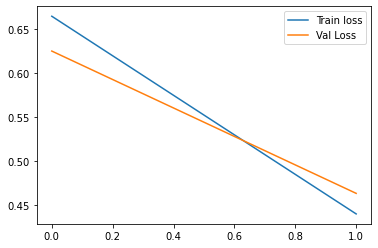

In [290]:
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend();

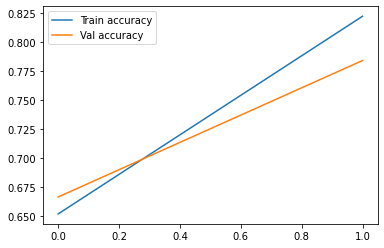

In [291]:
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Val accuracy')
plt.legend();

In [292]:
model_metrics_nn(model, 'Neural Network')

In [293]:
summary_df

,model,best_score,train_score,holdout_score,sensitivity,specificity,precision,f1_score,best_params
0,Gradient Boosting Classifier,0.955,0.996,0.853,0.149,0.982,0.321,0.204,"{'learning_rate': 0.12, 'max_depth': 4, 'n_est..."
1,Gradient Boosting Classifier,0.955,0.974,0.936,0.149,0.982,0.321,0.204,"{'learning_rate': 0.12, 'max_depth': 4, 'n_est..."
2,Neural Network,,0.840,0.757,0.719,0.759,0.148,0.246,
3,Neural Network with Dropout,,0.934,0.879,0.482,0.902,0.223,0.305,
4,Neural Network with Early Stopping,,0.892,0.808,0.632,0.818,0.168,0.265,
5,Neural Network with Early Stopping,,0.928,0.860,0.535,0.879,0.205,0.296,
6,Neural Network with Early Stopping,,0.905,0.833,0.614,0.846,0.188,0.288,
7,Neural Network,,0.672,0.408,0.912,0.379,0.079,0.145,
8,Neural Network,,0.852,0.784,0.702,0.789,0.162,0.263,


### Neural Network with Dropout

In [294]:
Xsm_train.shape[1]

238

In [295]:
# the turn-on and off are during each mini-batch run

from tensorflow.keras.layers import Dropout

model_dropout = Sequential()

n_input = Xsm_train.shape[1]
n_hidden = n_input

model_dropout.add(Dense(n_hidden, input_dim=n_input, activation='relu'))
model_dropout.add(Dropout(0.2))
model_dropout.add(Dense(64, activation='relu'))
model_dropout.add(Dropout(0.2))
model_dropout.add(Dense(1, activation='sigmoid'))

model_dropout.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# history = model.fit(Xsm_train, ysm_train, validation_data=(Xs_holdout, y_holdout), epochs=2, batch_size=512, verbose=0)
history_dropout = model_dropout.fit(
    Xsm_train,
    ysm_train,
    validation_data=(Xs_holdout, y_holdout), 
    epochs=1,
    batch_size=None
)

368/368 [==============================] - 1s 2ms/step - loss: 0.3512 - accuracy: 0.8452 - val_loss: 0.3985 - val_accuracy: 0.8295


In [296]:
model_metrics_nn(model_dropout, 'Neural Network with Dropout')

In [297]:
summary_df

,model,best_score,train_score,holdout_score,sensitivity,specificity,precision,f1_score,best_params
0,Gradient Boosting Classifier,0.955,0.996,0.853,0.149,0.982,0.321,0.204,"{'learning_rate': 0.12, 'max_depth': 4, 'n_est..."
1,Gradient Boosting Classifier,0.955,0.974,0.936,0.149,0.982,0.321,0.204,"{'learning_rate': 0.12, 'max_depth': 4, 'n_est..."
2,Neural Network,,0.840,0.757,0.719,0.759,0.148,0.246,
3,Neural Network with Dropout,,0.934,0.879,0.482,0.902,0.223,0.305,
4,Neural Network with Early Stopping,,0.892,0.808,0.632,0.818,0.168,0.265,
5,Neural Network with Early Stopping,,0.928,0.860,0.535,0.879,0.205,0.296,
6,Neural Network with Early Stopping,,0.905,0.833,0.614,0.846,0.188,0.288,
7,Neural Network,,0.672,0.408,0.912,0.379,0.079,0.145,
8,Neural Network,,0.852,0.784,0.702,0.789,0.162,0.263,
9,Neural Network with Dropout,,0.922,0.829,0.596,0.843,0.181,0.278,


### Neural Network with Early Stopping

In [274]:
from tensorflow.keras.callbacks import EarlyStopping

# Build model using early stopping
model_es = Sequential()

n_input = Xsm_train.shape[1]

model_es.add(Dense(64, input_dim=n_input, activation='relu'))
model_es.add(Dense(1, activation='sigmoid'))

model_es.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

history_es = model_es.fit(
    Xsm_train,
    ysm_train,
    validation_data=(Xs_holdout, y_holdout),
    epochs=1,
    batch_size=None,
    callbacks=[early_stop]
)

368/368 [==============================] - 0s 1ms/step - loss: 0.3852 - accuracy: 0.8354 - val_loss: 0.3529 - val_accuracy: 0.8333


In [277]:
model_metrics_nn(model_es, 'Neural Network with Early Stopping')

In [278]:
summary_df

,model,best_score,train_score,holdout_score,sensitivity,specificity,precision,f1_score,best_params
0,Gradient Boosting Classifier,0.955,0.996,0.853,0.149,0.982,0.321,0.204,"{'learning_rate': 0.12, 'max_depth': 4, 'n_est..."
1,Gradient Boosting Classifier,0.955,0.974,0.936,0.149,0.982,0.321,0.204,"{'learning_rate': 0.12, 'max_depth': 4, 'n_est..."
2,Neural Network,,0.840,0.757,0.719,0.759,0.148,0.246,
3,Neural Network with Dropout,,0.934,0.879,0.482,0.902,0.223,0.305,
4,Neural Network with Early Stopping,,0.892,0.808,0.632,0.818,0.168,0.265,
5,Neural Network with Early Stopping,,0.928,0.860,0.535,0.879,0.205,0.296,
6,Neural Network with Early Stopping,,0.905,0.833,0.614,0.846,0.188,0.288,


### AUC-ROC Curve

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12,10))
plot_roc_curve(cvec_lr_gs, X_test, y_test, ax=ax, name='LogisticRegression-CVEC(GS)', color='lightgrey')
plot_roc_curve(cvec_nb_gs, X_test, y_test, ax=ax, name='MultinomialNB-CVEC(GS)', color='lightgrey')
plot_roc_curve(tvec_svc_gs, X_test, y_test, ax=ax, name='SupportVectorClassifier-TVEC(GS)', color='lightgrey')
plot_roc_curve(tvec_lr_gs, X_test, y_test, ax=ax, name='LogisticRegression-TVEC(GS)', color='blue')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Random Guess')
plt.legend()